***Adapted from Google developer's ML scratch course***
   - https://developers.google.com/machine-learning/crash-course

## Objectives
  * Fundamental TensorFlow concepts
  * Use the `LinearRegressor` class in TensorFlow to predict median housing price, at the granularity of city blocks, based on one input feature
  * Evaluate the accuracy of a model's predictions using Root Mean Squared Error (RMSE)
  * Improve the accuracy of a model by tuning its hyperparameters

## Setup
**Loading the necessary libraries**

In this notebook, we use TensorFlow 1.x via the %tensorflow_version 1.x

In [10]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics


import tensorflow as tf
print(tf.__version__)


2.0.0


The tf_upgrade_v2** utility is included automatically with a pip install of TF 2.0, and will help accelerate the  upgrade processes by **converting existing TensorFlow 1.13 Python scripts to TensorFlow 2.0.**

---
To ensure the code is still supported in TensorFlow 2.0, the upgrade script includes a compat.v1 module. This module will replace calls of the form tf.foo with equivalent tf.compat.v1.foo references. It is recommended, however, to manually proofread such replacements and migrate them to new APIs in tf.* namespace instead of tf.compat.v1.* namespace as quickly as feasible.


In [21]:
from tensorflow.python.data import Dataset
#tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

## Data : Housing price in California District

---
Let's load the data set

In [24]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we'll scale median_house_value to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [35]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
11996,-121.4,38.6,41.0,2577.0,365.0,913.0,339.0,6.3,0.0
12285,-121.5,38.6,38.0,2410.0,967.0,1091.0,829.0,1.2,0.0
8227,-118.4,34.0,22.0,3970.0,871.0,1588.0,791.0,4.9,0.0
11395,-121.2,38.0,30.0,1055.0,211.0,629.0,170.0,2.9,0.0
15603,-122.3,37.9,41.0,268.0,75.0,198.0,82.0,3.2,0.0


---
Examine the data
---
It's a good idea to get to know your data a little bit before you work with it.

We'll print out a quick summary of a few useful statistics on each column: count of examples, mean, standard deviation, max, min, and various quantiles.

In [36]:
california_housing_dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,17000.0,-119.6,2.0,-124.3,-121.8,-118.5,-118.0,-114.3
latitude,17000.0,35.6,2.1,32.5,33.9,34.2,37.7,42.0
housing_median_age,17000.0,28.6,12.6,1.0,18.0,29.0,37.0,52.0
total_rooms,17000.0,2643.7,2179.9,2.0,1462.0,2127.0,3151.2,37937.0
total_bedrooms,17000.0,539.4,421.5,1.0,297.0,434.0,648.2,6445.0
population,17000.0,1429.6,1147.9,3.0,790.0,1167.0,1721.0,35682.0
households,17000.0,501.2,384.5,1.0,282.0,409.0,605.2,6082.0
median_income,17000.0,3.9,1.9,0.5,2.6,3.5,4.8,15.0
median_house_value,17000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
Build the Linear Regression Model 
---

### - <b> Step 1 : </b> Define Features and Configure Feature Columns

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this notebook

- <b> Categorical Data: </b> Data that is textual. In this exercise, our housing data set does not contain any categorical features, but examples you might see would be the home style, the words in a real-estate ad.

- <b> Numerical Data:</b> Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical.
    
--- 

In TensorFlow, we indicate a feature's data type using a construct called a feature column. Feature columns store only a description of the feature data ; they do not contain the feature data itself.

To start, we're going to use just one numeric input feature, total_rooms. The following code pulls the total_rooms data from our california_housing_dataframe and defines the feature column using numeric_column, which specifies its data is numeric:


In [37]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

### - <b> Step 2 : </b> Define the Target

In [39]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]

### - <b> Step 3 : </b> Configure the LinearRegressor

We'll configure a linear regression model using LinearRegressor. We'll train this model using the GradientDescentOptimizer, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

---
To be safe, we also apply gradient clipping to our optimizer via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail.


In [85]:
# Use gradient descent as the optimizer for training the model.
#my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
my_optimizer=tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer=tf.compat.v1.clip_by_value(targets,clip_value_min=0, clip_value_max=30)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns,optimizer=my_optimizer)

 ### - <b> Step 4 : </b> Define the Input Function

To import our California housing data into our `LinearRegressor`, we need to define an input function, which instructs TensorFlow how to preprocess ; the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our *pandas* feature data into a dict of NumPy arrays. We can then use the TensorFlow [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) to construct a dataset object from our data, and then break our data into batches of `batch_size`, to be repeated for the specified number of epochs (num_epochs). 

**IMPORTANT:** When the default value of `num_epochs=None` is passed to `repeat()`, the input data will be repeated indefinitely.

Next, if `shuffle` is set to `True`, we'll shuffle the data so that it's passed to the model randomly during training. The `buffer_size` argument specifies the size of the dataset from which `shuffle` will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

In [86]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

 ### - <b> Step 5 : </b> Train the model

We can now call `train()` on our `linear_regressor` to train the model. We'll wrap `my_input_fn` in a `lambda`

In [87]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(my_feature,targets)
df_train=pd.concat([X_train,y_train], axis=1, sort=True)
df_test=pd.concat([X_test,y_test], axis=1, sort=True)
train_input_fn = make_input_fn(df_train, y_train)
test_input_fn = make_input_fn(df_test,y_test)


In [94]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.compat.v1.clip_by_value(targets,clip_value_min=0, clip_value_max=30)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

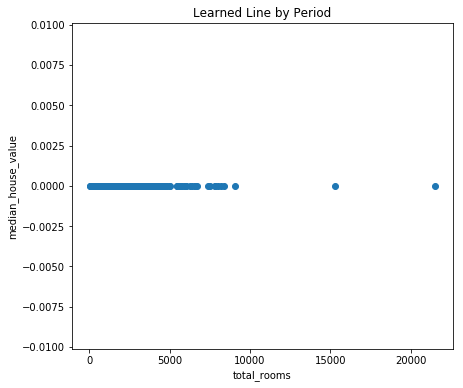

In [95]:
result=train_model(0.0001, 25, 1000, input_feature="total_rooms")